# Project: Image Classification and Regression MVA - CentraleSupelec
# Etudiant: <span style="color:red">Raymond Ji</span>
<br>
<br>

In [1]:
import keras
import sys
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, UpSampling2D, GlobalAveragePooling2D, Flatten, Reshape

Using TensorFlow backend.


# 2. Getting started

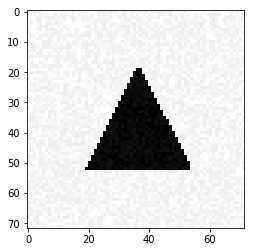

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    for i in range(nb_samples):
        if i % 10 == 0:
            sys.stdout.write("\rCreating data: %s / %s" % (i+10,nb_samples))
            sys.stdout.flush()
            #print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = keras.utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    for i in range(nb_samples):
        if i % 10 == 0:
            sys.stdout.write("\rCreating data: %s / %s" % (i+10,nb_samples))
            sys.stdout.flush()
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression(nb_samples = 300,noise=20):
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(nb_samples, noise)
    return [X_test, Y_test]



### Custom auxiliary function to plot model loss/accuracy/MAE

In [3]:
def plot_history(history,label,val_label):
    plt.plot(history.history[label])
    plt.plot(history.history[val_label])
    plt.title('model '+label)
    plt.ylabel(label)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

# 3. Simple classification

In [4]:
from keras.utils import to_categorical
[X_train, Y_train] = generate_dataset_classification(300, 20)
Y_train = to_categorical(Y_train)


Creating data: 300 / 300

**Classification labels**: [1,0,0] for a rectangle, [0,1,0] for a disk and [0,0,1] for a triangle

In [5]:
display(Y_train[:5])

array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

Simple neural network model:

In [6]:
def standard_model(optimizer):
    model = Sequential()
    model.add(Dense(128, input_dim=5184, kernel_initializer='normal',activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, kernel_initializer='normal',activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, kernel_initializer='normal',activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(3, kernel_initializer='normal',activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=['accuracy'])
    model.summary()
    return model


### Optimizer SGD

In [7]:
model_sgd = standard_model('sgd')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               663680    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 99        
Total para

In [8]:
epochs = 100
history = model_sgd.fit(X_train,Y_train,validation_split=0.33,epochs=epochs,batch_size =32)

Train on 200 samples, validate on 100 samples
Epoch 1/100
200/200 [==============================] - 0s 2ms/step - loss: 1.0967 - acc: 0.3800 - val_loss: 1.0937 - val_acc: 0.4500
Epoch 2/100
200/200 [==============================] - 0s 394us/step - loss: 1.1006 - acc: 0.3050 - val_loss: 1.0929 - val_acc: 0.4600
Epoch 3/100
200/200 [==============================] - 0s 382us/step - loss: 1.0919 - acc: 0.3550 - val_loss: 1.0917 - val_acc: 0.4700
Epoch 4/100
200/200 [==============================] - 0s 429us/step - loss: 1.0886 - acc: 0.3750 - val_loss: 1.0910 - val_acc: 0.4600
Epoch 5/100
200/200 [==============================] - 0s 413us/step - loss: 1.0944 - acc: 0.3550 - val_loss: 1.0909 - val_acc: 0.4900
Epoch 6/100
200/200 [==============================] - 0s 471us/step - loss: 1.0992 - acc: 0.3500 - val_loss: 1.0886 - val_acc: 0.4800
Epoch 7/100
200/200 [==============================] - 0s 482us/step - loss: 1.0920 - acc: 0.3900 - val_loss: 1.0831 - val_acc: 0.4800
Epoch 8/100

Epoch 61/100
200/200 [==============================] - 0s 404us/step - loss: 0.5340 - acc: 0.6700 - val_loss: 0.4435 - val_acc: 0.6900
Epoch 62/100
200/200 [==============================] - 0s 460us/step - loss: 0.5026 - acc: 0.6900 - val_loss: 0.4941 - val_acc: 0.6600
Epoch 63/100
200/200 [==============================] - 0s 367us/step - loss: 0.5209 - acc: 0.7050 - val_loss: 0.4515 - val_acc: 0.6900
Epoch 64/100
200/200 [==============================] - 0s 360us/step - loss: 0.4986 - acc: 0.7400 - val_loss: 0.4595 - val_acc: 0.7000
Epoch 65/100
200/200 [==============================] - 0s 358us/step - loss: 0.5060 - acc: 0.6850 - val_loss: 0.5359 - val_acc: 0.6200
Epoch 66/100
200/200 [==============================] - 0s 360us/step - loss: 0.4983 - acc: 0.7200 - val_loss: 0.4356 - val_acc: 0.8300
Epoch 67/100
200/200 [==============================] - 0s 339us/step - loss: 0.5031 - acc: 0.7150 - val_loss: 0.4264 - val_acc: 0.8300
Epoch 68/100
200/200 [==========================

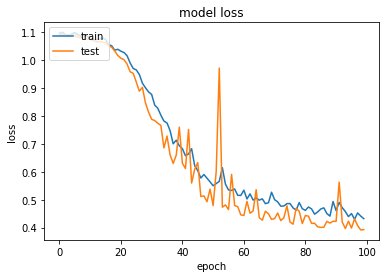

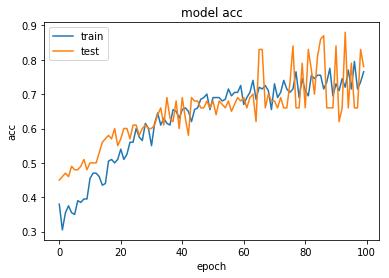

In [9]:
plot_history(history,'loss','val_loss')
plot_history(history,'acc','val_acc')

### Optimizer Adam

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               663680    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 99        
Total para

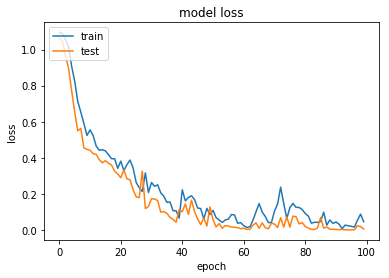

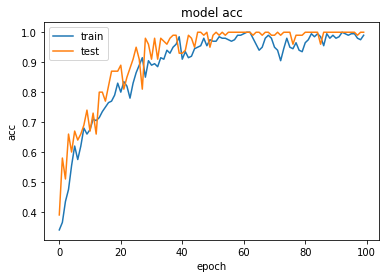

In [10]:
model_adam = standard_model('adam')
epochs = 100
history = model_adam.fit(X_train,Y_train,validation_split=0.33,epochs=epochs,batch_size =32,verbose=0)
plot_history(history,'loss','val_loss')
plot_history(history,'acc','val_acc')

<span style="color:red">***Observation***</span>: Optimizer ADAM seems to be more performant than SGD for this architecture.

### Test with a triangle, rectangle and disk with SGD optimizer

[[1.0000000e+00 2.9721868e-38 0.0000000e+00]]


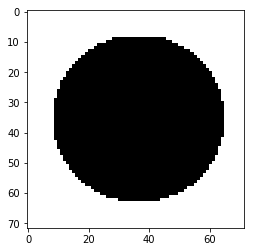

[[1.0000000e+00 1.0660682e-13 0.0000000e+00]]


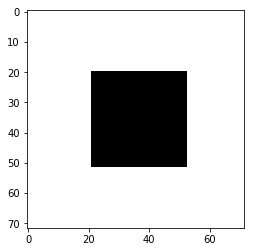

[[0. 0. 1.]]


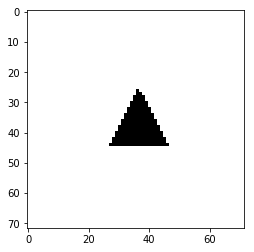

In [11]:
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
plt.imshow(X_test.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
print(model_sgd.predict(X_test))
plt.show()


X_test = generate_a_rectangle()
X_test = X_test.reshape(1, X_test.shape[0])
plt.imshow(X_test.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
print(model_sgd.predict(X_test))
plt.show()

[X_test, v] = generate_a_triangle()
plt.imshow(X_test.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
X_test = X_test.reshape(1, X_test.shape[0])
print(model_sgd.predict(X_test))
plt.show()

<span style="color:red">***Observation***</span>: We correctly classified each of the 3 shapes.

# 4. Visualization of the solution

Visualize last layer.

In [12]:
print(model_sgd.get_weights()[4].shape)
print(model_sgd.get_weights()[4])

(64, 3)
[[-0.01883791  0.01577174  0.05717459]
 [ 0.04006481 -0.08640106 -0.02084095]
 [-0.01944436  0.00253558  0.06746257]
 [-0.01043628 -0.07349347 -0.0022253 ]
 [ 0.06246622  0.10085438 -0.14034133]
 [ 0.07105055  0.05000015 -0.03710965]
 [ 0.05865127 -0.05882274  0.10054755]
 [ 0.0394532  -0.05657698 -0.10298269]
 [ 0.07874159  0.06355779 -0.16476515]
 [-0.00718138 -0.03951201 -0.00686883]
 [ 0.08367053  0.13489577 -0.06190277]
 [ 0.07471858 -0.03222491 -0.09199163]
 [ 0.0902163  -0.01010095  0.11059194]
 [-0.00394759 -0.02544557  0.05280245]
 [ 0.02022155 -0.22462198  0.09224338]
 [ 0.06404993 -0.00382629  0.0035788 ]
 [-0.06271416 -0.08375315  0.06118107]
 [ 0.06758668  0.11229636 -0.2331641 ]
 [-0.08624116 -0.01766944  0.07631008]
 [ 0.10830576  0.15345073 -0.07273715]
 [ 0.04758105  0.09175568 -0.16173741]
 [-0.09144989  0.02143018  0.08794578]
 [-0.06056523 -0.01570971  0.15707758]
 [-0.01224818 -0.04901557  0.0837264 ]
 [-0.14214961  0.12257693 -0.02507841]
 [-0.07899701 -0.

# 5. A More Difficult Classification Problem

In [13]:
[X_train, Y_train] = generate_dataset_classification(300, 20, True)
Y_train = to_categorical(Y_train)

Creating data: 300 / 300

Reshaping for convolutional layers:

In [14]:
X_train = X_train.reshape(-1, IMAGE_SIZE,IMAGE_SIZE, 1)
X_train.shape

(300, 72, 72, 1)

In [15]:
def convolutional_model():
    model = Sequential()
    model.add(Conv2D(filters = 16, kernel_size = (5,5), strides = 1, padding = 'valid', activation = 'relu', 
                     input_shape=X_train.shape[1:]))
    model.add(MaxPooling2D(pool_size=2, strides=None, padding='same'))
    model.add(Conv2D(filters = 32, kernel_size = 2, padding = 'same', activation = 'relu'))
    model.add(MaxPooling2D(pool_size=2, strides=None, padding='valid'))
    model.add(Conv2D(filters = 64, kernel_size = 2, padding = 'same', activation = 'relu'))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model
model = convolutional_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 68, 68, 16)        416       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 34, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 17, 17, 64)        8256      
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 195       
Total para

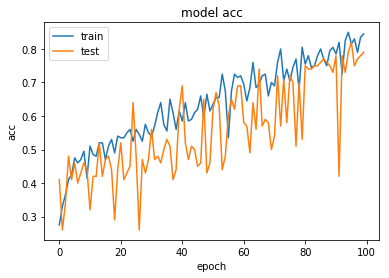

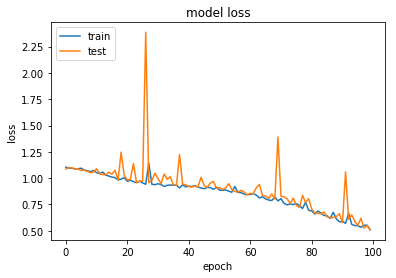

In [16]:
epochs = 100
history = model.fit(X_train,Y_train,validation_split=0.33,epochs=epochs,batch_size =32,verbose = 0)

plot_history(history,'acc','val_acc')
plot_history(history,'loss','val_loss')

Create testing set:

In [17]:
[X_test, Y_test] = generate_test_set_classification()
X_test = X_test.reshape(-1, IMAGE_SIZE,IMAGE_SIZE, 1)

Creating data: 300 / 300

Testing results:

In [18]:
print(model.evaluate(X_test, Y_test))
print(model.metrics_names)

300/300 [==============================] - 1s 2ms/step
[0.5344758343696594, 0.8166666674613953]
['loss', 'acc']


<span style="color:red">***Observation***</span>: We obtained an accuracy of $\geq 80\%$ on the dataset with noise.

Example

[0.6678022  0.11392301 0.21827477]


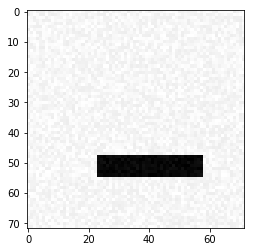

[0.04617415 0.06864079 0.8851851 ]


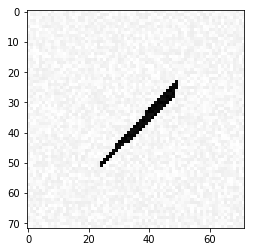

[0.5372298  0.16725945 0.29551077]


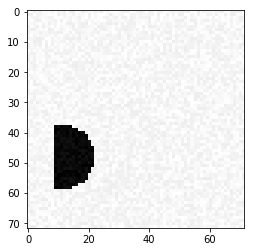

In [19]:
num_images = 3
random_idx = np.random.randint(X_test.shape[0],size=num_images)

for i, idx in enumerate(random_idx):
    plt.imshow(X_test[idx].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
    print(model.predict(X_test)[idx])
    plt.show()

# 6. A Regression Problem

The task now is to predict the image locations of the vertices of a triangle, given an image of this
triangle.

In [20]:
[X_train, Y_train] = generate_dataset_regression(3000, 0)
[X_test, Y_test] = generate_test_set_regression(300,0)


Creating data: 300 / 30000

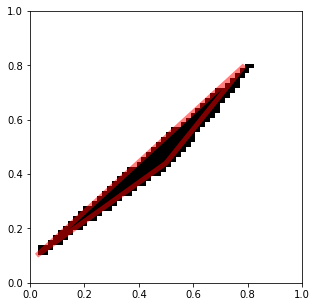

Coordonnees:
 [[0.02423682 0.10027496]
 [0.78895755 0.79976045]
 [0.49988263 0.44032761]]


In [21]:
visualize_prediction(X_train[0], Y_train[0])
print("Coordonnees:\n",Y_train[0].reshape(3,2))

### Normalization

The current Y_train is: <br>
$Points: A(x1,y1),B(x2,y2),C(x3,y3)$ <br>
$Y: [x1, y1, x2, y2, x3, y3]$ <br>

If we switch the order of A,B and C, we should still have the same triangle. 
However, currently , the algorithm will see this as two different triangles (different order in y_train) and will learn badly.
To solve this problem, we "***normalize***" the edges by sorting the 3 points from left to right along x axis.

In [22]:
def transform(vertices):
    arr = vertices.reshape(3,2)
    return arr[arr[:,0].argsort()].reshape(6)

def transform_list(vertices):
    return np.array([transform(y) for y in vertices])


Example of what our transformation does:

In [23]:
print("Before:\n",Y_train[0].reshape(3,2))
print("After:\n",transform_list(Y_train)[0].reshape(3,2))

Before:
 [[0.02423682 0.10027496]
 [0.78895755 0.79976045]
 [0.49988263 0.44032761]]
After:
 [[0.02423682 0.10027496]
 [0.49988263 0.44032761]
 [0.78895755 0.79976045]]


Apply transformation to all dataset:

In [24]:
Y_train = transform_list(Y_train)
Y_test = transform_list(Y_test)

Regression model

In [25]:
def regression_model():
    model = Sequential()
    model.add(Dense(256, input_dim=5184, kernel_initializer='normal',activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, kernel_initializer='normal',activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, kernel_initializer='normal',activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(6, kernel_initializer='normal',activation='relu'))
    sgd = SGD(lr=0.01, momentum=0.9, decay=0, nesterov=False)
    model.compile(loss='mean_squared_error', optimizer=sgd)
    model.summary()    
    return model

model = regression_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 256)               1327360   
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 6)                 390       
Total para

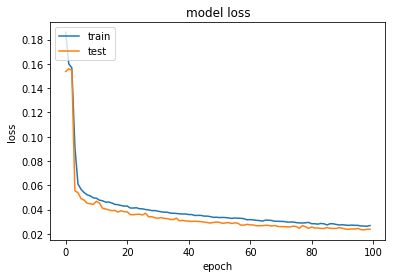

In [26]:
epochs = 100
history = model.fit(X_train,Y_train,validation_split=0.33,epochs=epochs,batch_size =32,verbose = 0)
plot_history(history,'loss','val_loss')

Visualization:

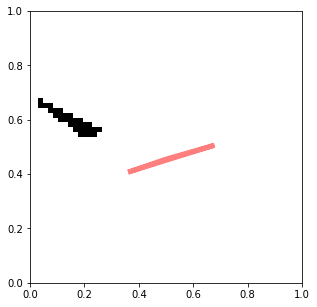

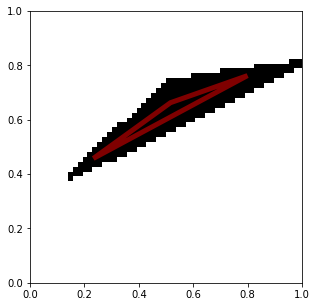

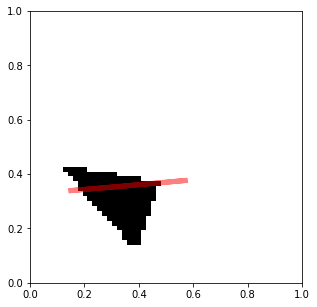

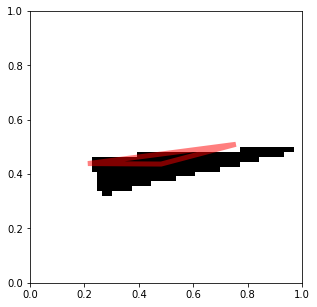

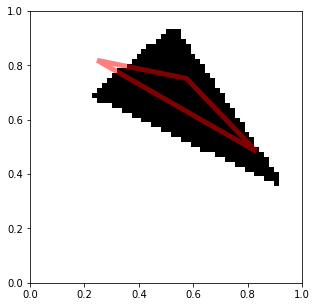

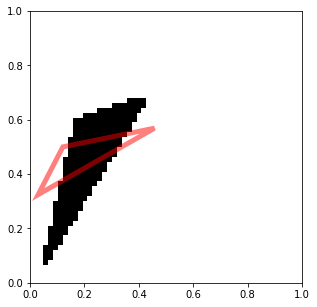

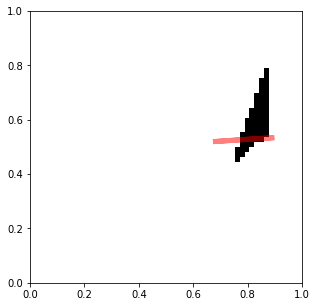

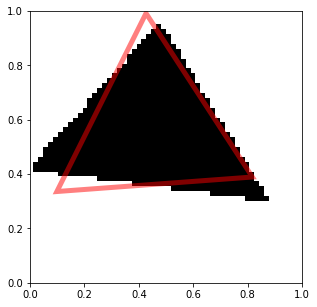

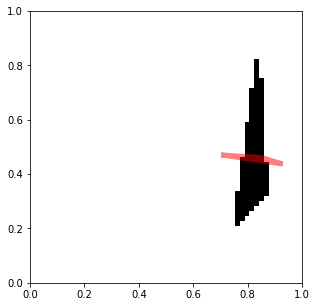

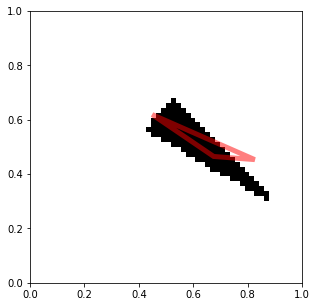

In [27]:
num_images = 10
random_idx = np.random.randint(X_test.shape[0],size=num_images)
pred= model.predict(X_test)
for i, idx in enumerate(random_idx):
    visualize_prediction(X_test[idx],pred[idx])

***Observation***: For figures that are very "thin" it doesn't work out yet but for figures that are "bigger" it is already quite close.

# 7. Image denoising

Implement a hourglass network for denoising: Modifying the generate_a_* functions to generate
pairs of images, where one image has noise with random amplitude, and the second image has the
same content but without the noise. Train your network to predict a noise-free image given a noisy
image as input.

Modified generate-a-* functions:

In [28]:
def generate_a_drawing_bis(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata_with_noise = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata, imdata_with_noise

def generate_a_rectangle_bis(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing_bis(figsize, U, V, noise)


def generate_a_disk_bis(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing_bis(figsize, U, V, noise)

def generate_a_triangle_bis(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing_bis(figsize, U, V, noise)
    return imdata

def generate_dataset_w_noise(nb_samples, noise=0.0, free_location=False):
    '''
    Return two lists, the first contains random figures, the second contains the same figures with random noise
    '''
    # Getting im_size:
    im_size = generate_a_rectangle_bis()[0].shape[0]
    # X is the normal data
    X = np.zeros([nb_samples,im_size])
    # Y is the noised data
    Y = np.zeros([nb_samples,im_size])
    for i in range(nb_samples):
        sys.stdout.write("\rCreating data: %s / %s" % (i+1,nb_samples))
        sys.stdout.flush()
        category = np.random.randint(3)
        if category == 0:
            X[i], Y[i] = generate_a_rectangle_bis(noise, free_location)
        elif category == 1: 
            X[i], Y[i] = generate_a_disk_bis(noise, free_location)
        else:
            X[i], Y[i] = generate_a_triangle_bis(noise, free_location)
    return X, Y


Generate two datasets: one contains random figures, the other contains the same figures with random noise

In [29]:
data, data_w_noise = generate_dataset_w_noise(1000, noise=40, free_location=True)

# Scaling
max_value = float(data.max())
data = data.astype('float32') / max_value
data_w_noise = data_w_noise.astype('float32') / max_value

Creating data: 1000 / 1000

Example

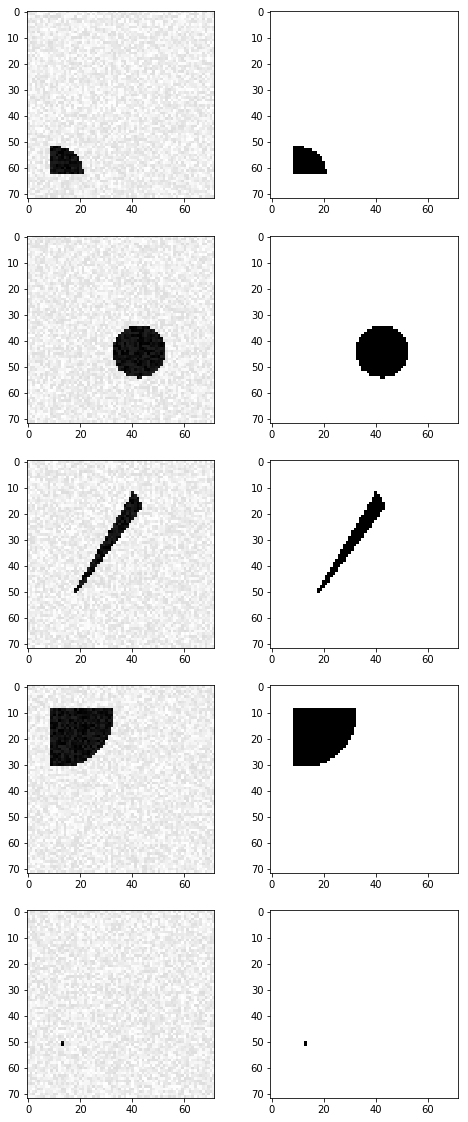

In [30]:
n = 5
fig, ax = plt.subplots(n, 2, figsize=(8, 20))
for i in range(0,n):
    ax[i][0].imshow(data_w_noise[i].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
    ax[i][1].imshow(data[i].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

Training/testing split:

In [31]:
X_train = data_w_noise[:len(data)*2//3]
Y_train = data[:len(data)*2//3]

X_test = data_w_noise[len(data)*2//3:]
Y_test = data[len(data)*2//3:]

print("Size training set:",X_train.shape)
print("Size validation set:",X_test.shape)

Size training set: (666, 5184)
Size validation set: (334, 5184)


In [32]:
data2D = data.reshape(-1, 72,72, 1)
data_w_noise2D = data_w_noise.reshape(-1, 72,72, 1)

X_train2D = data_w_noise2D[:len(data)*2//3]
Y_train2D = data2D[:len(data)*2//3]

X_test2D = data_w_noise2D[len(data)*2//3:]
Y_test2D = data2D[len(data)*2//3:]

I chose to use an ***auto-encoder*** model for denoising.

In [33]:
def my_autoencoder():
    model = Sequential()

    # Encoder Layers
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=X_train2D.shape[1:]))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))

    # Decoder Layers
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

    model.summary()
    return model

autoencoder = my_autoencoder()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 72, 72, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 36, 36, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 18, 18, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 18, 18, 32)        9248      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 36, 36, 32)        9248      
__________

Train on 446 samples, validate on 220 samples
Epoch 1/50
446/446 [==============================] - 13s 30ms/step - loss: 0.5967 - val_loss: 0.3694
Epoch 2/50
446/446 [==============================] - 13s 29ms/step - loss: 0.2795 - val_loss: 0.2508
Epoch 3/50
446/446 [==============================] - 12s 27ms/step - loss: 0.2420 - val_loss: 0.2751
Epoch 4/50
446/446 [==============================] - 12s 26ms/step - loss: 0.2269 - val_loss: 0.2060
Epoch 5/50
446/446 [==============================] - 11s 26ms/step - loss: 0.1911 - val_loss: 0.1864
Epoch 6/50
446/446 [==============================] - 13s 28ms/step - loss: 0.1615 - val_loss: 0.1570
Epoch 7/50
446/446 [==============================] - 12s 26ms/step - loss: 0.1330 - val_loss: 0.1234
Epoch 8/50
446/446 [==============================] - 12s 26ms/step - loss: 0.1018 - val_loss: 0.0882
Epoch 9/50
446/446 [==============================] - 12s 27ms/step - loss: 0.0706 - val_loss: 0.0601
Epoch 10/50
446/446 [===============

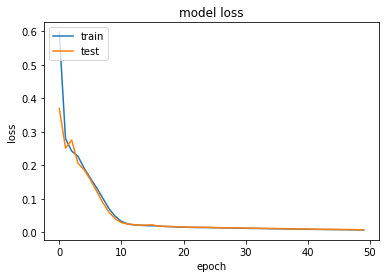

In [34]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(X_train2D, Y_train2D,
                epochs=50,
                batch_size=128,
                validation_split=0.33)
plot_history(history,'loss','val_loss')

### Testing

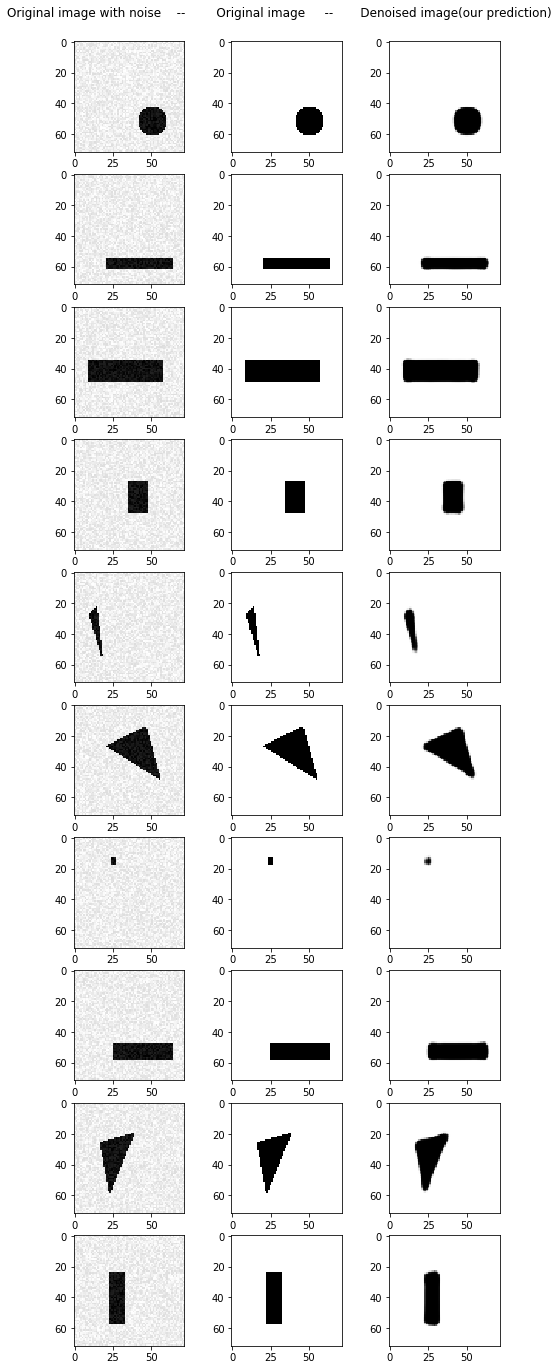

In [35]:
decoded_imgs = autoencoder.predict(X_test2D)

num_images = 10
random_idx = np.random.randint(X_test.shape[0],size=num_images)
fig, ax = plt.subplots(num_images, 3, figsize=(8, 24))
for i, idx in enumerate(random_idx):
    ax[i][0].imshow(X_test[idx].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
    ax[i][1].imshow(Y_test[idx].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
    ax[i][2].imshow(decoded_imgs[idx].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.suptitle("Original image with noise    --        Original image     --       Denoised image(our prediction)",x=0.5,y=0.9)

plt.show()

<span style="color:red">***Observation***</span>: Very good results, algorithm output is very close to original image.